# Imports & variable definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os

from sklearn.ensemble import RandomForestRegressor

In [2]:
country_set = ['South Africa', 'Nigeria', 'India', 'China', 'Japan', 
               'South Korea', 'Germany', 'Poland', 'France', 'United Kingdom', 
               'Finland', 'Brazil', 'Bolivia', 'Colombia', 'Saudi Arabia', 'Iran', 
               'Egypt', 'United States', 'Canada', 'Mexico']

start_year, end_year = 2015, 2021

# Happiness data input and preprocessing

In [3]:
# Read in data
happiness_data = {}

for f in os.listdir('../data/WHI/'):
    year = f.split('.')[0]
    happiness_data[year] = pd.read_csv('../data/WHI/' + f)

# Unify column names
happiness_data['2017'].rename(columns={'Happiness.Score': 'Happiness Score'}, inplace=True)

happiness_data['2018'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)
happiness_data['2019'].rename(columns={'Country or region':'Country',
                        'Score':'Happiness Score'}, inplace=True)

happiness_data['2020'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)
happiness_data['2021'].rename(columns={'Country name': 'Country',
                        'Ladder score':'Happiness Score'}, inplace=True)

happiness_data['2022'].rename(columns={'Happiness score': 'Happiness Score'}, inplace=True)

# Change number format for 2022 data to match other data
happiness_data['2022']['Happiness Score'] = happiness_data['2022']['Happiness Score'].str.replace(',', '.').astype(float)

# Remove every column except Country, Region and Happiness Score and add a column for the year
for df in happiness_data:
    happiness_data[df] = happiness_data[df][['Country', 'Happiness Score']]
    happiness_data[df]['Year'] = df

# Merge all years in one frame
happiness_df = pd.concat(happiness_data, ignore_index=True)

happiness_df

,Country,Happiness Score,Year
0,Switzerland,7.587,2015
1,Iceland,7.561,2015
2,Denmark,7.527,2015
3,Norway,7.522,2015
4,Canada,7.427,2015
...,...,...,...
1226,Benin,3.484,2016
1227,Afghanistan,3.360,2016
1228,Togo,3.303,2016
1229,Syria,3.069,2016


In [4]:
# Remove invalid countries
happiness_df.drop(happiness_df.loc[happiness_df['Country'] == 'xx'].index, inplace=True)

# Convert Year to int
happiness_df['Year'] = happiness_df['Year'].astype(int)

# Filter to only include the countries we want to predict
happiness_df = happiness_df.loc[happiness_df['Country'].isin(country_set)].copy()

# Filter to 2015-2021
happiness_df = happiness_df.loc[happiness_df['Year'].isin(range(start_year, end_year+1))]

# Sort by year
happiness_df.sort_values(by=['Year'], inplace=True)

happiness_df.head()

,Country,Happiness Score,Year
4,Canada,7.427,2015
116,India,4.565,2015
112,South Africa,4.642,2015
109,Iran,4.686,2015
83,China,5.140,2015


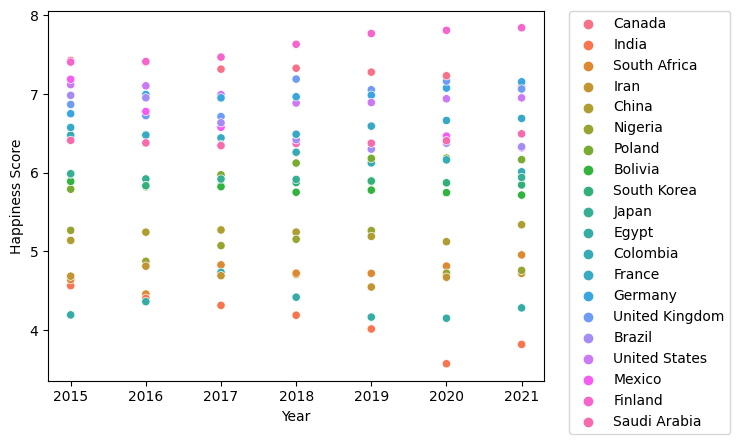

In [5]:
# Plot data for each country
hp_plt = sns.scatterplot(data=happiness_df, x='Year', y='Happiness Score', hue='Country')
hp_plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [6]:
#rng = np.random.RandomState(42) #Beispieldaten aus zwei Schwingungen
#x = 10 * rng.rand(200)

#def model(x, sigma=0.3):
#    fast_oscillation = np.sin(5 * x)
#    slow_oscillation = np.sin(0.5 * x)
#    noise = sigma * rng.randn(len(x))
#
#    return slow_oscillation + fast_oscillation + noise

#y = model(x)
#plt.errorbar(x, y, 0.3, fmt='o'); # Konfidenzintervall

## Enrich happiness data

### Human rights data

In [7]:
hr_df = pd.read_csv('../data/human_rights.csv')

# Filter to 2015-2021
hr_df = hr_df.loc[hr_df['Year'].isin(range(start_year, end_year+1))]

# Drop and rename columns
hr_df.drop(columns=['Code', 'region'], inplace=True)
hr_df.rename(columns={'Entity': 'Country', 'civ_libs_vdem_owid':'Human Rights Score'}, inplace=True)

# Filter to country set
hr_df = hr_df[hr_df['Country'].isin(country_set)]

hr_df.loc[hr_df['Human Rights Score'].isna()]

,Country,Year,Human Rights Score


### CO2 emissions per capita data

In [8]:
co2_df = pd.read_excel('../data/co2_emissions.xlsx', sheet_name='fossil_CO2_per_capita_by_countr')

# Drop unnecessary columns
co2_df.drop(columns=['EDGAR Country Code','Substance'], inplace=True)

# Melt frame
co2_df = pd.melt(co2_df, id_vars=['Country'], var_name='Year', value_name='CO2 Emissions per capita in tons')

# Filter to 2015-2021
co2_df = co2_df.loc[co2_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
co2_df = co2_df[co2_df['Country'].isin(country_set)]

co2_df.loc[co2_df['CO2 Emissions per capita in tons'].isna()]

,Country,Year,CO2 Emissions per capita in tons


### Population growth in % data

In [9]:
pg_df = pd.read_csv('../data/population_growth.csv')

# Remove unnecessary columns
pg_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', '1960', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
pg_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Melt frame
pg_df = pd.melt(pg_df, id_vars=['Country'], var_name='Year', value_name='Population Growth % per year')

# Convert Year to int
pg_df['Year'] = pg_df['Year'].astype(int)

# Filter to 2015-2021
pg_df = pg_df.loc[pg_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
pg_df = pg_df[pg_df['Country'].isin(country_set)]

pg_df.loc[pg_df['Population Growth % per year'].isna()]

,Country,Year,Population Growth % per year


### Military expenditure % of GDP data

In [10]:
me_df = pd.read_csv('../data/military_expenditure.csv')

# Drop unnecessary columns
me_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', '1960', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
me_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Melt frame
me_df = pd.melt(me_df, id_vars=['Country'], var_name='Year', value_name='Military Expenditure % of GDP')

# Convert Year to int
me_df['Year'] = me_df['Year'].astype(int)

# Filter to 2015-2021
me_df = me_df.loc[me_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
me_df = me_df[me_df['Country'].isin(country_set)]

me_df.loc[me_df['Military Expenditure % of GDP'].isna()]

,Country,Year,Military Expenditure % of GDP


### Inflation of consumer prices data

In [11]:
if_df = pd.read_csv('../data/inflation_consumer_prices.csv')

# Drop unnecessary columns
if_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', '1960', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
if_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Melt frame
if_df = pd.melt(if_df, id_vars=['Country'], var_name='Year', value_name='Inflation % consumer prices')

# Convert Year to int
if_df['Year'] = if_df['Year'].astype(int)

# Filter to 2015-2021
if_df = if_df.loc[if_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
if_df = if_df[if_df['Country'].isin(country_set)]

if_df.loc[if_df['Inflation % consumer prices'].isna()]

,Country,Year,Inflation % consumer prices


### Power consumption per capita data

In [15]:
pc_df = pd.read_csv('../data/per-capita-energy-use.csv')

# Drop unnecessary columns
pc_df.drop(columns=['Code'], inplace=True)

# Rename country column to match other frames
pc_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Filter to 2015-2021
pc_df = pc_df.loc[pc_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
pc_df = pc_df[pc_df['Country'].isin(country_set)]

pc_df.loc[pc_df['Primary energy consumption per capita (kWh/person)'].isna()]

,Country,Year,Primary energy consumption per capita (kWh/person)


### Rural population % of total population data

In [19]:
rp_df = pd.read_csv('../data/rural_population.csv')

# Drop unnecessary columns
rp_df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 67'], inplace=True)

# Rename country column to match other frames
rp_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# Melt frame
rp_df = pd.melt(rp_df, id_vars=['Country'], var_name='Year', value_name='Rural Population % of total population')

# Convert Year to int
rp_df['Year'] = rp_df['Year'].astype(int)

# Filter to 2015-2021
rp_df = rp_df.loc[rp_df['Year'].isin(range(start_year, end_year+1))]

# Filter to country set
rp_df = rp_df[rp_df['Country'].isin(country_set)]

rp_df.loc[rp_df['Rural Population % of total population'].isna()]

,Country,Year,Rural Population % of total population


# Data analysis with Random Forest Regressor

In [46]:
forest = RandomForestRegressor(200) # Number of decision trees
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

NameError: name 'x' is not defined